# Topic Modeling

In [249]:
import pandas as pd
import numpy as np
import wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.colors as mcolors
from nltk.corpus import stopwords
from collections import Counter
import text_cleaning_helper_functions as hlf

In [251]:
# open csv and continue cleaning
df = pd.read_csv('final_df.csv')
df.isna().any()
df.dropna(inplace=True)

# ensure single digits and single letters are excluded
df['reviews'] = df['reviews'].replace(r'\d+?', ' ', regex=True)
df['reviews'] = df['reviews'].replace(r'\s[a-z]\s', ' ', regex=True)
stop_words = stopwords.words('english')

In [252]:
# shuffle the reviews and split them into train and test groups - for classification purposes
all_reviews =  df.copy(deep=True)['reviews']
all_reviews = all_reviews.sample(frac=1).reset_index(drop=True)
train_reviews = all_reviews.copy(deep=True)[:401000]
test_reviews =  all_reviews.copy(deep=True)[401000:]

In [253]:
# separate df for join the topic components on
reviews_concat = all_reviews.copy(deep=True)

In [254]:
# sanity check
print(len(train_reviews))
print(len(test_reviews))
print(len(all_reviews))

401000
100828
501828


In [255]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split

# LDA

In [33]:
def print_topics(model, features, n):
    ''' This model prints and saves the 'N' most important words from every topic '''
    # make sure the features is in a numpy array to use .argsort
    if type(features) == list:
        features = np.array(features)
    
    # save the n most important words for each topic
    components = model.components_ 
    top_n = [features[component.argsort()][-n-1:] for component in components]
    
    # print the top words for every each topic
    for i in range(len(top_n)):
        print(f"Topic {i+1} most important words: {top_n[i]}")
    return top_n

In [41]:
# vectorize the data and get check what the top words
tf_idf_vectorize = TfidfVectorizer(max_df=0.5, max_features=10000,
                                  min_df=10, use_idf=True)

tf_idf = tf_idf_vectorize.fit_transform(all_reviews)

# extract feature name and run LDA model (there are 14~ type of products in amazon's electronic department)
features = tf_idf_vectorize.get_feature_names()
LDA = LatentDirichletAllocation(n_components=14, random_state=1234,
                                n_jobs=-1, verbose=1).fit(tf_idf)

LDA_topics = hlf.print_topics(LDA, features , 14)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
Topic 1 most important words: ['reception' 'radio' 'screw' 'work' 'cable' 'wall' 'channel' 'signal'
 'mount' 'tv' 'antenna']
Topic 2 most important words: ['cord' 'charging' 'phone' 'plug' 'work' 'usb' 'cable' 'power' 'charger'
 'charge' 'battery']
Topic 3 most important words: ['hand' 'feel' 'like' 'battery' 'use' 'work' 'logitech' 'button' 'key'
 'keyboard' 'mouse']
Topic 4 most important words: ['memory' 'speed' 'data' 'file' 'hard' 'computer' 'work' 'gb' 'usb' 'card'
 'drive']
Topic 5 most important words: ['tablet' 'stand' 'hold' 'strap' 'like' 'kindle' 'bag' 'ipad' 'fit'
 'cover' 'case']
Topic 6 most important words: ['good' 'cover' 'work' 'dust' 'like' 'case' 'plastic' 'product' 'bubble'
 'pro

In [205]:
# add the topics to next to the reviews
LDA_topics = pd.DataFrame(LDA.transform(tf_idf))

# get the highest value from every row
max_val = LDA_topics.max(axis=1)

topic_names = [f"topic_{c}" for c in LDA_topics.columns]
LDA_topics.columns = topic_names

reviews_with_topics = pd.concat([reviews_concat, doc_topics, max_val], axis=1)
reviews_with_topics.head()

,reviews,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,0
0,audiophile wanted decent set earbuds replac...,0.011433,0.011433,0.011434,0.058429,0.011434,0.011433,0.815802,0.011433,0.011433,0.011433,0.011434,0.011434,0.011433,0.815802
1,iphone g iphone ipod touch nd gen th gen ...,0.017072,0.017072,0.017072,0.017072,0.091267,0.017072,0.017072,0.017072,0.720944,0.017071,0.017072,0.017072,0.017072,0.720944
2,day use salt water got inside antenna mount ...,0.016927,0.016927,0.016930,0.016927,0.016927,0.103957,0.016927,0.016927,0.344292,0.016928,0.016927,0.382476,0.016927,0.382476
3,bought security camera like others v input vid...,0.012028,0.023043,0.337049,0.012028,0.345856,0.012028,0.012029,0.012028,0.012028,0.012028,0.012029,0.012028,0.185797,0.345856
4,work guess window detected installed issue e...,0.012533,0.012533,0.012533,0.012533,0.625482,0.012533,0.012533,0.012533,0.012533,0.012533,0.236656,0.012533,0.012533,0.625482


# LDA Bigarm

In [43]:
# tfidf bigrams
tf_idf_n2_vec = TfidfVectorizer(max_df=0.5, max_features=10000,
                                min_df=10, use_idf=True, 
                                ngram_range=(1, 2))

# extract features name and run the model
tf_idf_n2 = tf_idf_n2_vec.fit_transform(all_reviews)
features_n2 = tf_idf_n2_vec.get_feature_names()

LDA_n2 = LatentDirichletAllocation(n_components=14, random_state=1234,
                                   n_jobs=-1, verbose=1).fit(tf_idf_n2)

LDA_n2_topics = hlf.print_topics(LDA_n2, features_n2 , 14)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
Topic 1 most important words: ['item' 'use' 'charge' 'bought' 'buy' 'easy' 'quality' 'work great'
 'recommend' 'product' 'good' 'great' 'work' 'price' 'battery']
Topic 2 most important words: ['problem' 'port' 'wireless' 'file' 'support' 'network' 'driver' 'device'
 'software' 'computer' 'usb' 'work' 'drive' 'router' 'window']
Topic 3 most important words: ['good' 'work' 'product' 'touch' 'stylus' 'use' 'like' 'ipad' 'bubble'
 'screen protector' 'tablet' 'key' 'protector' 'keyboard' 'screen']
Topic 4 most important words: ['netflix' 'device' 'ray' 'play' 'monitor' 'movie' 'picture' 'work'
 'cable' 'video' 'hdmi' 'dvd' 'player' 'remote' 'tv']
Topic 5 most important words: ['like' 'great' 'noise' 'pair

# Gensim LDA

In [256]:
import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from nltk.tokenize import word_tokenize 

In [ ]:
# tokenize reviews
tokened_reviews = [word_tokenize(i) for i in all_reviews]

# create dictionary and filter out words that appear in less than 10 documents or in more than 50% of documents 
dictionary = gensim.corpora.Dictionary(tokened_reviews)
dictionary.filter_extremes(no_below=10, no_above=0.5, keep_n=8000)

# create corpus
corpus = [dictionary.doc2bow(doc) for doc in tokened_reviews]

gensim_LDA = gensim.models.LdaMulticore(corpus=corpus, num_topics=10, id2word=dictionary, 
                                       passes=3, workers=4, per_word_topics=True,
                                       random_state=123)

# print the 7 most important words in every topic
for ind, words in gensim_LDA.print_topics(-1, 7):
    print(f'Topic {ind+1}: {words}')

In [202]:
def create_word_clouds(model, n=2, j=5, save=0, start=0, stop=None):
    """
    create_word_clouds(model, n, j, save, start, stop):
    Params:
        model: gensim LDA model object
        n: number of subplots in a column  (default=2)
        j: number of subplots in a row (default=5)
        save: save the figure (optional, default=0)
        start: from what number topic you wish to create the subplot (optional, default=0)
        stop: stop the subplot at a certain topic (optional, default=None)
        
    Returns:
        Word cloud image for every topic LDA created
    """
    # create color list
    colors_list = [color for name, color in mcolors.XKCD_COLORS.items()]
    
    # instantiate cloud
    cloud = WordCloud(background_color='white',
                      width=1028,
                      height=726,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: colors_list[start],
                      prefer_horizontal=1.0)
    
    # extract topics
    topics = model.show_topics(formatted=False)
    
    # create subplots 
    fig, axes = plt.subplots(n, j, figsize=(10,10), sharex=True, sharey=True)
    
    for ax in axes.flatten():
        fig.add_subplot(ax)
        topic_words = dict(topics[start][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(start+1), fontdict=dict(size=16))
        # hide axis
        plt.gca().axis('off')
        start += 1
        if start == stop:
            break
        
    plt.subplots_adjust(wspace=0, hspace=0)
    # hide axis
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    if save:
        plt.savefig(f'topics_cloud{start}.png')
    plt.show()

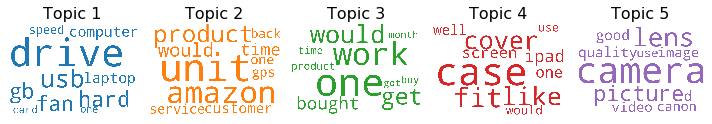

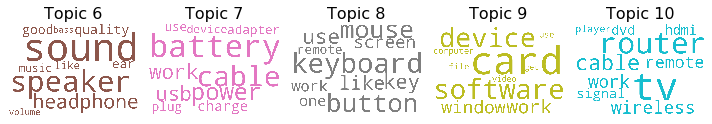

In [242]:
# plot and save the different topics. each word is sized by how many time they repeat
for start in [0, 5]:
    hlf.create_word_clouds(gensim_LDA, n=1, j=5, save=0, start=start)

In [ ]:
def word_count_importance(text, model, n=2, j=5, save=0, start=0, stop=None):
    topics = model.show_topics(formatted=False)
    for words_list in text:
        flatten_text = [word for word in words_list]
    
    counter = Counter(data_flat)
    
    pre_df = []
    for ind, topic in topics:
        for word, weight in topic:
            pre_df.append([i, word, weight, counter[word]])
    
    # create a dataframe from list of lists
    df = pd.DataFrame(out, columns=['Id', 'Word', 'Weight', 'Word_Count']) 
    
    # create subplots for the word count and weights for every topic
    fig, axes = plt.subplots(n, j, figsize=(10,10), sharey=True, dpi=160)
    colors_list = [color for name, color in mcolors.XKCD_COLORS.items()]
    
    for i, ax in enumerate(axes.flatten()):
        # create word count bars
        ax.bar(x='Word', height="Word_Count", data=df.loc[df.Id==i, :], 
               color=colors_list[i], width=0.5, alpha=0.3, label='Word Count')
        
        # create importance shadow
        ax_twin = ax.twinx()
        ax_twin.bar(x='Word', height="Weight", data=df.loc[df.Id==i, :], 
                    color=colors_list[i], width=0.6, label='Weights')
        
        
        ax.set_ylabel('Word Count', color=colors_list[i])
        ax.set_title('Topic: ' + str(i+1), color=colors_list[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df.loc[df.Id==i, 'Word'], rotation=30, 
                           horizontalalignment= 'right')


    fig.tight_layout()    
    fig.suptitle('Word Count and Importance For Every Topic', fontsize=22, y=1.05)    
    plt.show()
    return

In [246]:
gensim_LDA.show_topics(formatted=False)

[(0,
  [('drive', 0.050642926),
   ('usb', 0.015000728),
   ('hard', 0.010926389),
   ('gb', 0.010427561),
   ('fan', 0.010334441),
   ('computer', 0.00991536),
   ('laptop', 0.009789146),
   ('speed', 0.008336997),
   ('card', 0.0065638255),
   ('one', 0.005765333)]),
 (1,
  [('unit', 0.021831274),
   ('amazon', 0.013010585),
   ('product', 0.0104254335),
   ('would', 0.008110185),
   ('time', 0.008036804),
   ('customer', 0.0077562723),
   ('service', 0.0075044124),
   ('one', 0.007438247),
   ('gps', 0.007093899),
   ('back', 0.006736977)]),
 (2,
  [('one', 0.026766364),
   ('work', 0.016969195),
   ('would', 0.0136742825),
   ('get', 0.013427385),
   ('bought', 0.012999274),
   ('product', 0.012909216),
   ('time', 0.0126218125),
   ('buy', 0.011576403),
   ('month', 0.011030726),
   ('got', 0.01074377)]),
 (3,
  [('case', 0.0292801),
   ('fit', 0.012196796),
   ('cover', 0.010493651),
   ('like', 0.010364258),
   ('ipad', 0.009185784),
   ('screen', 0.009154837),
   ('one', 0.0089

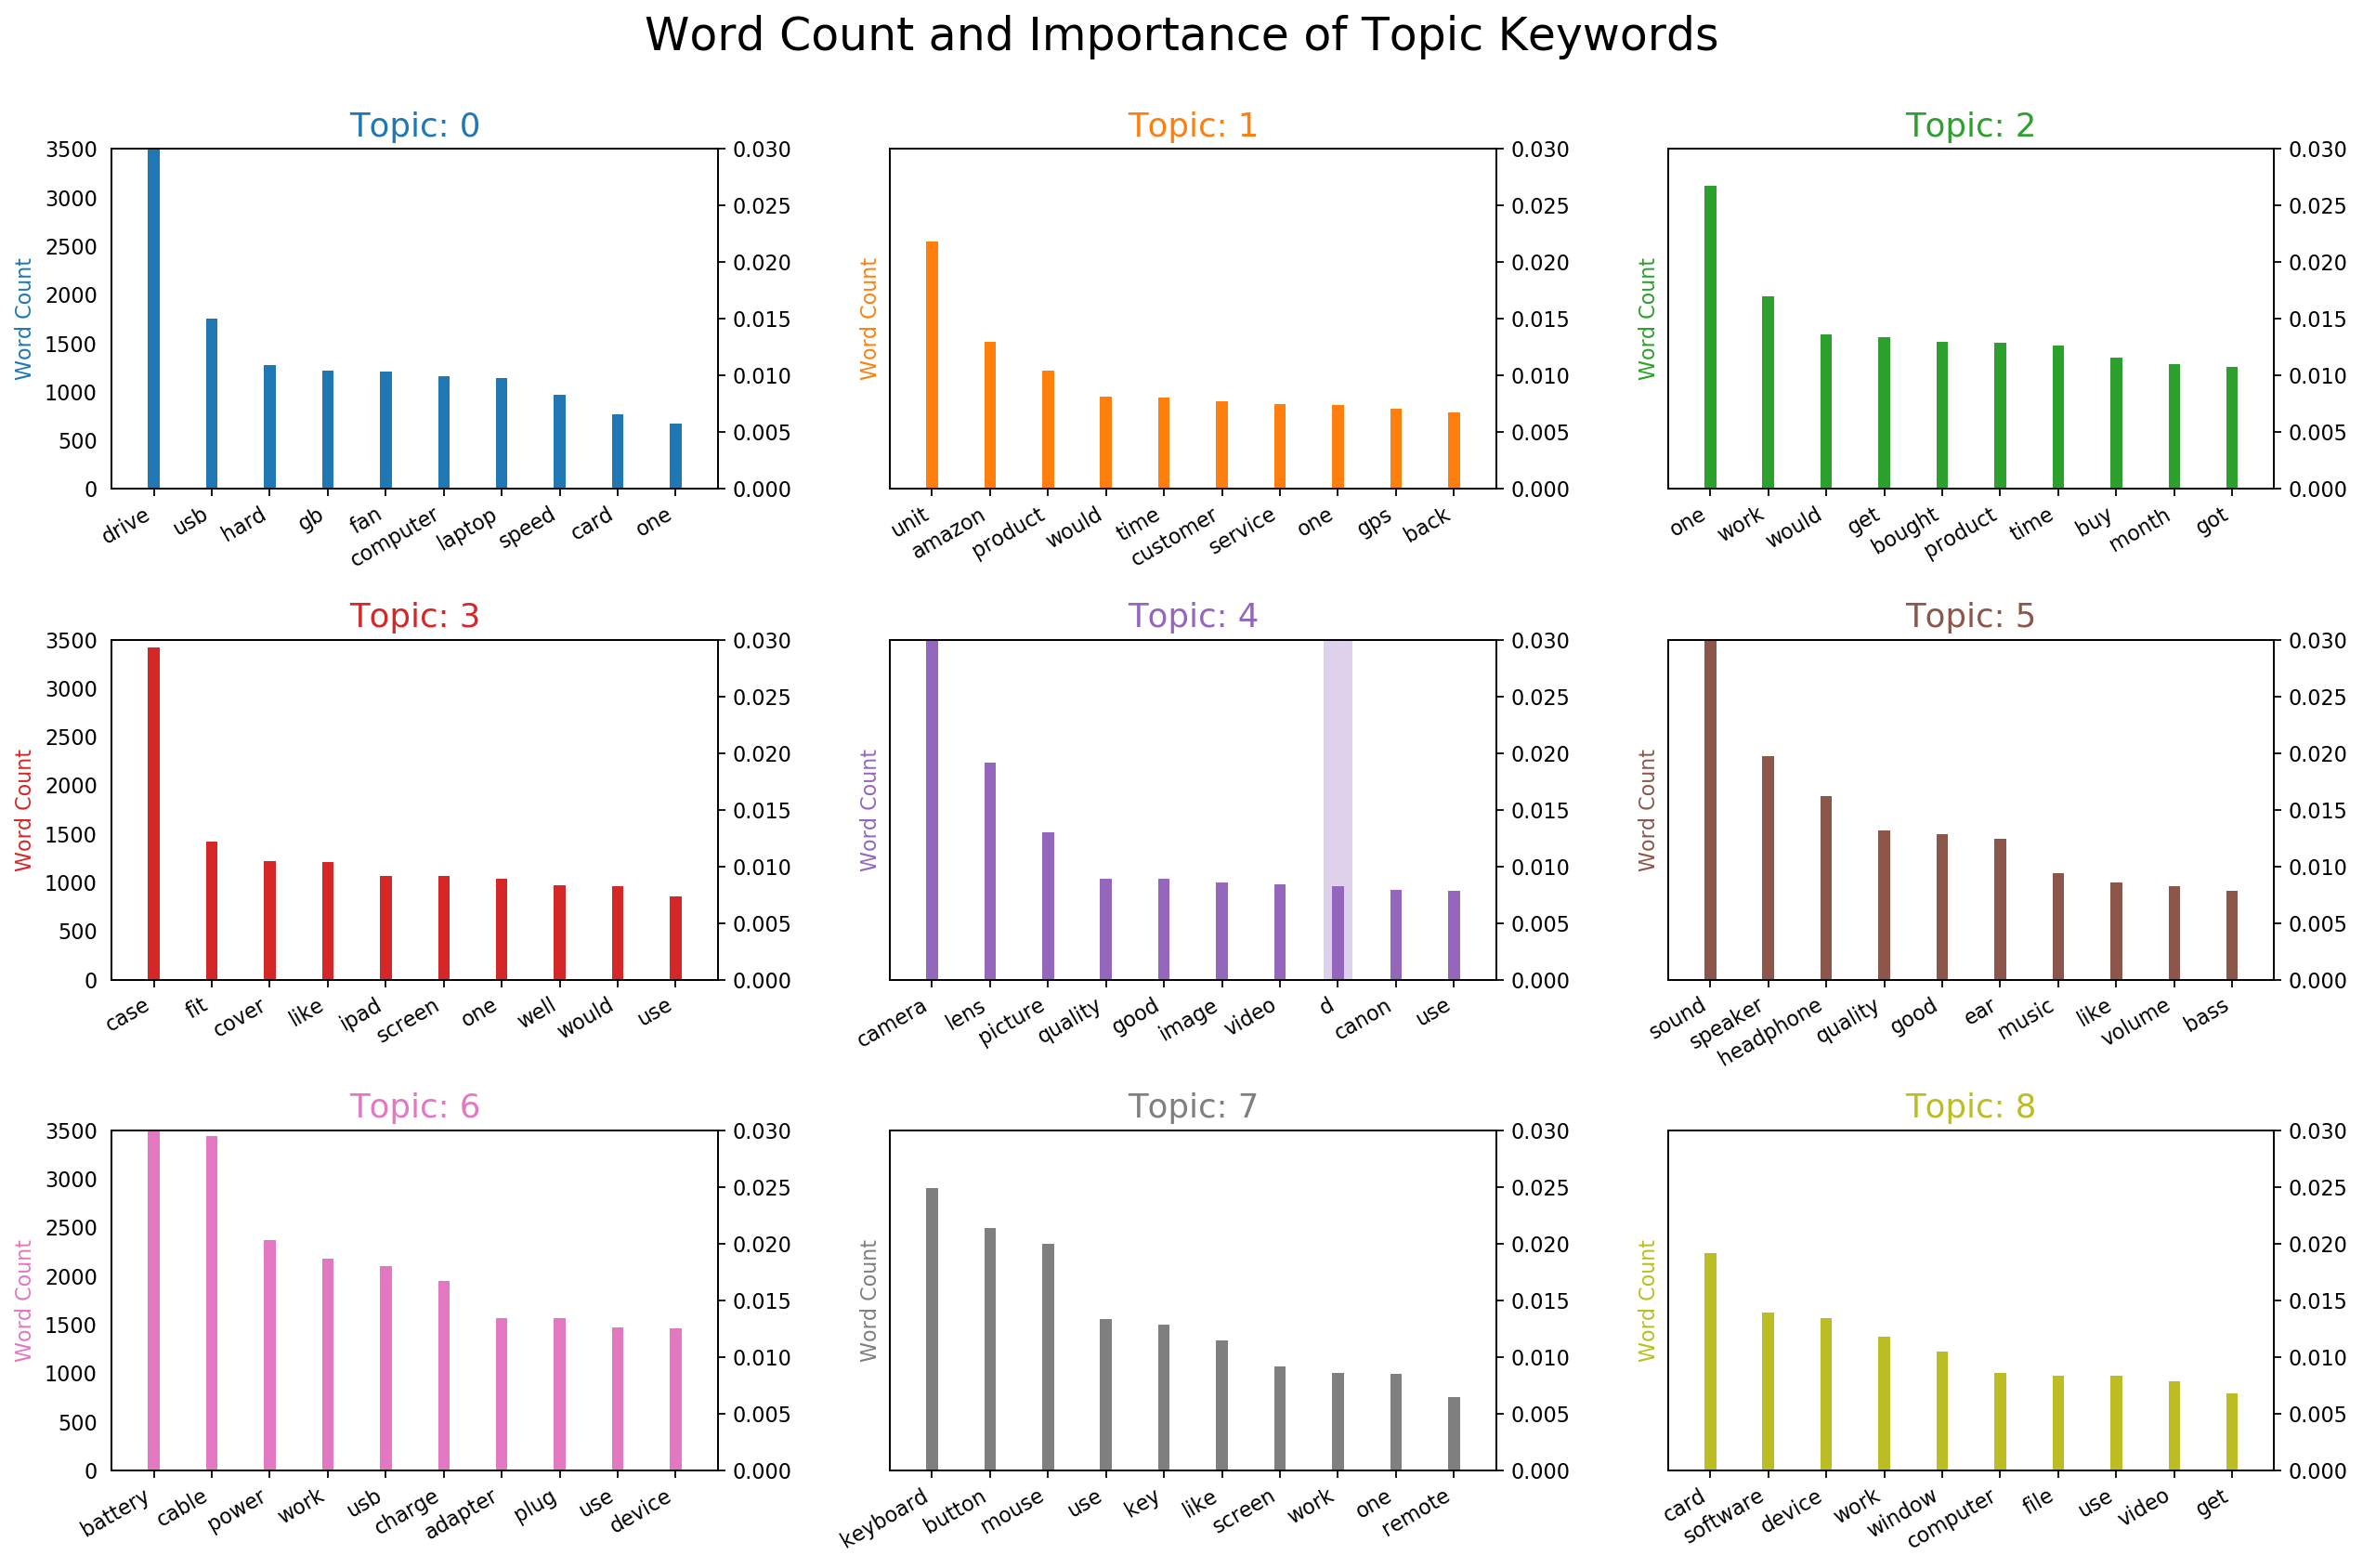

In [239]:
from collections import Counter
topics = gensim_LDA.show_topics(formatted=False)
data_flat = [w for w_list in all_reviews for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 3, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()